# コードのテスト
## grad_cam_by_command_line.py の関数について
- H3-031案件のgradcamモジュール
- モデルファイルからコマンドラインでGradCam実行

In [1]:
import os
#gpu_num = "0"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, base_predict

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

#sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
#from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.


get_train_valid_test.py: loaded as module file
my_generator.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
base_predict.py: loaded as module file


In [7]:
# grad_cam_by_command_line.py はクラス名ハードコードしてるから応用効かない。クラス変わるとコード変更必要
!python C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\predicter\grad_cam_by_command_line.py \
    D:\work\keras_iPhone_pictures\01_classes_results\20190122 \
    multiply_1 \
    331 331 \
    creative_commons_elephant.png \
    D:\work\keras_iPhone_pictures\01_classes_results\20190122 > gradcam.log


2019-01-26 00:48:49.838048: I C:\users\nwani\_bazel_nwani\mmtm6wb6\execroot\org_tensorflow\tensorflow\core\platform\cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-01-26 00:48:50.013295: I C:\users\nwani\_bazel_nwani\mmtm6wb6\execroot\org_tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.835
pciBusID: 0000:01:00.0
totalMemory: 8.00GiB freeMemory: 6.60GiB
2019-01-26 00:48:50.013719: I C:\users\nwani\_bazel_nwani\mmtm6wb6\execroot\org_tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:1435] Adding visible gpu devices: 0
2019-01-26 00:48:50.680112: I C:\users\nwani\_bazel_nwani\mmtm6wb6\execroot\org_tensorflow\tensorflow\core\common_runtime\gpu\gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-26 00:48:50.680376: I C:\users\nwani\_bazel_nwani\mmtm6wb6\e

## 本「PythonとKerasによるディープラーニング 」のGradCam

Predicted: [('n02504458', 'African_elephant', 0.38783565), ('n01871265', 'tusker', 0.31378606), ('n02504013', 'Indian_elephant', 0.1782888)]


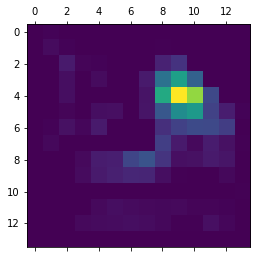

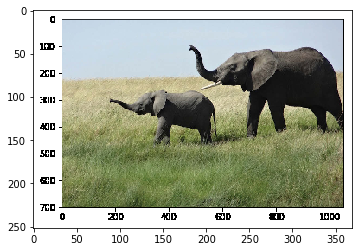

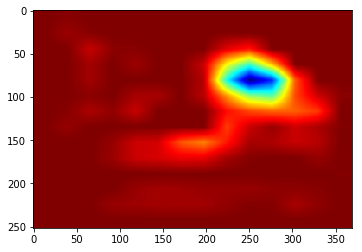

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


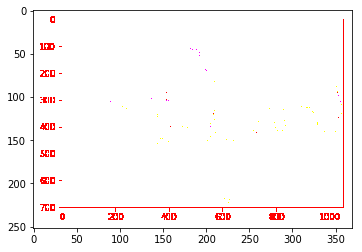

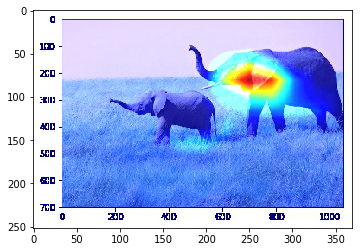

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

def preprocess(img_path):
    # ターゲット画像を読み込む：imgはサイズが224×224のPIL画像
    img = image.load_img(img_path, target_size=(224, 224))
    # xは形状が(224, 224, 3)のfloat32型のNumPy配列
    x = image.img_to_array(img)
    # この配列をサイズが(1, 224, 224, 3)のバッチに変換するために次元を追加
    # バッチの前処理（チャネルごとに色を正規化）
    X = preprocess_input(np.expand_dims(x, axis=0))
    return X, x

def text_VGG16_grad_cam(img_path='creative_commons_elephant.png'
                        , out_path='output_test/elephant_cam.jpg'
                        , model=VGG16(weights='imagenet')
                        , pred_id=386
                        , layer_name='block5_conv3'):
    
    x, x0 = preprocess(img_path)
    preds = model.predict(x)
    print('Predicted:', decode_predictions(preds, top=3)[0])

    from keras import backend as K
    # 予測ベクトルの「アフリカゾウ」エントリ(pred_id=386)
    african_elephant_output = model.output[:, pred_id]
    # VGG16の最後の畳み込み層であるblock5_conv3の出力特徴マップ
    last_conv_layer = model.get_layer(layer_name)
    # block5_conv3の出力特徴マップでの「アフリカゾウ」クラスの勾配
    grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
    # 形状が(512,)のベクトル：
    # 各エントリは特定の特徴マップチャネルの勾配の平均強度
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    # 2頭のアフリカゾウのサンプル画像に基づいて、pooled_gradsと
    # block5_conv3の出力特徴マップの値にアクセスするための関数
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    # これら2つの値をNumPy配列として取得
    pooled_grads_value, conv_layer_output_value = iterate([x])
    # 「アフリカゾウ」クラスに関する「このチャネルの重要度」を
    # 特徴マップ配列の各チャネルに掛ける
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # 最終的な特徴マップのチャネルごとの平均値が
    # クラスの活性化のヒートマップ
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    import matplotlib.pyplot as plt
    %matplotlib inline
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()

    import cv2
    # cv2を使って元の画像を読み込む
    img = cv2.imread(img_path)
    # 元の画像と同じサイズになるようにヒートマップのサイズを変更
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # ヒートマップをRGBに変換
    heatmap = np.uint8(255 * heatmap)
    # ヒートマップを元の画像に適用
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # 0.4はヒートマップの強度係数
    #superimposed_img = heatmap * 0.4 + img
    superimposed_img = heatmap * 1.0 + img
    # 画像をディスクに保存
    cv2.imwrite('output_test/elephant_cam.jpg', superimposed_img)
    plt.imshow(img)
    plt.show()
    plt.imshow(heatmap)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    
text_VGG16_grad_cam()
util.show_file_img('output_test/elephant_cam.jpg')

## grad_cam.grad_cam
### 上の結果と同じになる

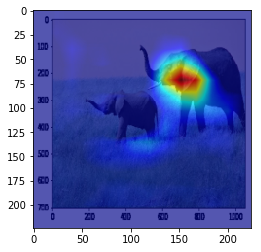

In [3]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = 'output_test'

model=VGG16(weights='imagenet')
X, x = preprocess('creative_commons_elephant.png')

layer_name = 'block5_conv3'
jetcam = grad_cam.grad_cam(model, X, x, layer_name, 224, 224, model.output[:, 386])
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

In [4]:
%%time
train_batch_size=68#17
valid_batch_size=37#6
shape=[100, 100, 3]
out_dir='output_test/100x100'

# ラベル情報などが書いたcsvファイル（tox21_compoundData.csv）
csv_path = r'../../storage/tox21_compoundData.csv'
# IDにファイルのフルパスつける
img_dir = r'../../storage/img/Wash/100x100/'
# 画像ファイルのサフィックス
img_suffix = r'_000.jpg'
# 欠損値を-1に置換したtox21_compoundData.csvのデータフレーム
df = prepare_data.make_label_df(csv_path, img_dir, img_suffix=img_suffix)
# Tox21の画像のパスとラベル(y_train,y_valid,y_test)を取得する
train_files, validation_files, test_files, y_train, y_valid, y_test = prepare_data.make_train_val_test(df)

d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.load_train_as_image(train_files, y_train)
d_cls.load_validation_as_image(validation_files, y_valid)
d_cls.load_test_as_image(test_files, y_test)

training_set_y.shape: (11764, 12)
validation_set_y.shape: (296, 12)
test_set_y.shape: (647, 12)
CPU times: user 7.62 s, sys: 2.9 s, total: 10.5 s
Wall time: 17.1 s


## grad_cam.nobranch_multi_grad_cam
###  出力画像のTP/TN/FP/FN合ってる+スコアの値がpredict/* .tsvの結果と一致している

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 49, 49, 96)   2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 49, 49, 96)   384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 96)   0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

__________________________________________________________________________________________________
separable_conv_2_normal_left5_1 (None, 4, 4, 672)    457632      activation_211[0][0]             
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 4, 4, 672)    2688        separable_conv_2_normal_left1_14[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 4, 4, 672)    2688        separable_conv_2_normal_right1_14
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 4, 4, 672)    2688        separable_conv_2_normal_left2_14[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 4, 4, 672)    2688        separable_conv_2_normal_right2_14
__________

/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/01_code_test/../../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


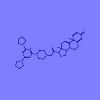

In [5]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test')

model = keras.models.load_model(os.path.join(out_dir, 'test_model.h5'), compile=False)
model.summary()
layer_name = 'activation_260'

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_test[0]*255.0
input_img_name = 'test0'

y_true = d_cls.y_test[0]

# 1画像について各タスクのGradCamを計算
grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

## grad_cam.branch_multi_grad_cam
###  出力画像のTP/TN/FP/FN合ってる+スコアの値がpredict/* .tsvの結果と一致している

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 49, 49, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 49, 49, 32)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/01_code_test/../../predicter/grad_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()# camのピクセルの値を0-1に正規化


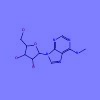

In [7]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation')

model = keras.models.load_model(os.path.join(out_dir, 'test_model_12branch.h5'), compile=False)
model.summary()
layer_name = 'mixed10'

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_valid[0]*255.0
input_img_name = 'valid0'

y_true = d_cls.y_valid[0]

# 1画像について各タスクのGradCamを計算
grad_cam.branch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])